### This notebook explores a stock-pairs trading strategy. There are two components to the strategy 1) Use Dynamic Time Warping and K-means to cluster stocks for the purpose of choosing "good" stock-pairs. 2) Use a Kalman Filter to predict the "expected" spread between the two stocks, and trade the spread when the expected spread is one standard deviation away from the "actual" spread.

In [1]:
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean

In [2]:
%matplotlib inline 

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cv2
from PIL import Image
import math
import scipy.io
from sklearn import manifold
from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.decomposition import PCA

from IPython import display
from IPython.core.display import Image

# special matplotlib command for global plot configuration
from matplotlib import rcParams
import matplotlib.cm as cm
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap



import tensorflow as tf

from sklearn.preprocessing import StandardScaler

In [3]:
from __future__ import print_function
from pandas_datareader import DataReader
from pykalman import KalmanFilter

In [4]:
#import zipfile
#zip_ref = zipfile.ZipFile("C:/Users/rchang/Documents/Robert/Personal/CSCI E-82/Final Project/sp500.zip", 'r')
#zip_ref.extractall("C:/Users/rchang/Documents/Robert/Personal/CSCI E-82/Final Project/sp500_unzipped")

In [5]:
data=pd.read_csv('C:/Users/rchang/Documents/Robert/Personal/CSCI E-82/Final Project/Final_Project_Kamel_Chang/sp500_unzipped/data_stocks.csv')

### In addition to creating a dataframe of prices, we also create a dataframe of log returns. Log returns are used for clustering, prices are used for the Kalman Filter.

In [6]:
df = data.interpolate()
df_ret = np.log(1 + df.pct_change(1)).drop('DATE', axis=1) # We "normalize" the data by looking at daily log returns instead of absolute prices
df_ret = pd.concat([df.iloc[:,0], df_ret], axis=1)
df_ret = df_ret.iloc[1:]

In [7]:
df_ret.drop(df_ret.columns[125:502], axis=1, inplace=True)

In [8]:
df_new = df.copy()
df_new.drop(df_new.columns[125:502], axis=1, inplace=True)

In [9]:
df_new.drop(df_new.columns[0:1], axis=1, inplace=True)
df_new = df_new.transpose()

In [10]:
df_new.head()

,0,1,2,3,4,5,6,7,8,9,...,41256,41257,41258,41259,41260,41261,41262,41263,41264,41265
SP500,2363.6101,2364.1001,2362.6799,2364.3101,2364.8501,2365.6201,2365.200,2365.29,2364.3201,2364.6399,...,2471.8899,2472.77,2472.8999,2472.6399,2472.02,2472.22,2471.77,2470.030,2471.49,2471.49
NASDAQ.AAL,42.3300,42.3600,42.3100,42.3700,42.5378,42.5399,42.470,42.47,42.3900,42.3300,...,44.7200,44.73,44.7600,44.7500,44.71,44.72,44.73,44.740,44.71,44.74
NASDAQ.AAPL,143.6800,143.7000,143.6901,143.6400,143.6600,143.7800,143.864,143.81,143.8150,143.8000,...,164.1600,164.06,164.1900,164.2000,164.14,164.11,164.12,164.010,163.88,163.98
NASDAQ.ADBE,129.6300,130.3200,130.2250,130.0729,129.8800,130.0700,130.180,130.14,130.1000,130.2100,...,155.0600,155.01,155.1200,155.0900,155.04,155.09,155.16,155.065,154.96,155.16
NASDAQ.ADI,82.0400,82.0800,82.0300,82.0000,82.0350,82.0400,82.120,82.19,82.2300,82.1650,...,83.7100,83.70,83.6300,83.6900,83.66,83.67,83.65,83.620,83.58,83.69


In [11]:
df_ret.head()

,DATE,SP500,NASDAQ.AAL,NASDAQ.AAPL,NASDAQ.ADBE,NASDAQ.ADI,NASDAQ.ADP,NASDAQ.ADSK,NASDAQ.AKAM,NASDAQ.ALXN,...,NASDAQ.VRSN,NASDAQ.VRTX,NASDAQ.WBA,NASDAQ.WDC,NASDAQ.WFM,NASDAQ.WLTW,NASDAQ.WYNN,NASDAQ.XLNX,NASDAQ.XRAY,NASDAQ.ZION
1,1491226260,0.000207,0.000708,0.000139,0.005309,0.000487,-0.000881,0.005033,0.001338,-0.000329,...,-0.003894,0.000000,0.000959,-0.000302,-0.002360,0.007046,0.007366,0.002930,0.000321,0.002378
2,1491226320,-0.000601,-0.001181,-0.000069,-0.000729,-0.000609,0.000710,-0.001636,-0.000752,0.003697,...,0.000344,-0.001056,0.000959,-0.004665,0.000000,0.000000,0.005132,-0.000666,-0.000160,0.000238
3,1491226380,0.000690,0.001417,-0.000349,-0.001169,-0.000366,-0.000710,-0.000267,-0.002931,-0.004027,...,0.001032,0.000505,0.000164,0.002789,-0.001013,-0.001986,0.001468,-0.002264,-0.002408,-0.001664
4,1491226440,0.000228,0.003953,0.000139,-0.001484,0.000427,-0.000784,0.002487,0.000000,0.001317,...,-0.000802,0.005127,-0.000523,-0.001758,-0.003045,0.000185,-0.002559,0.003274,0.000482,0.003088
5,1491226500,0.000326,0.000049,0.000835,0.001462,0.000061,-0.000196,0.002563,-0.000168,0.000822,...,-0.000115,0.000493,0.000000,0.002727,0.001355,-0.001027,-0.007463,0.000344,0.002728,0.000000


In [12]:
df_iso = df_ret.copy()

In [13]:
df_iso.drop(df_iso.columns[0:1], axis=1, inplace=True)

In [14]:
df_iso = df_iso.transpose()
df_iso.head()

,1,2,3,4,5,6,7,8,9,10,...,41256,41257,41258,41259,41260,41261,41262,41263,41264,41265
SP500,0.000207,-0.000601,0.000690,0.000228,0.000326,-0.000178,0.000038,-0.000410,0.000135,-0.000025,...,-0.000251,0.000356,0.000053,-0.000105,-0.000251,0.000081,-0.000182,-0.000704,0.000591,0.000000
NASDAQ.AAL,0.000708,-0.001181,0.001417,0.003953,0.000049,-0.001645,0.000000,-0.001885,-0.001416,0.001652,...,-0.000447,0.000224,0.000670,-0.000223,-0.000894,0.000224,0.000224,0.000224,-0.000671,0.000671
NASDAQ.AAPL,0.000139,-0.000069,-0.000349,0.000139,0.000835,0.000584,-0.000375,0.000035,-0.000104,0.000626,...,-0.000152,-0.000609,0.000792,0.000061,-0.000365,-0.000183,0.000061,-0.000670,-0.000793,0.000610
NASDAQ.ADBE,0.005309,-0.000729,-0.001169,-0.001484,0.001462,0.000845,-0.000307,-0.000307,0.000845,-0.000538,...,0.000000,-0.000323,0.000709,-0.000193,-0.000322,0.000322,0.000451,-0.000612,-0.000677,0.001290
NASDAQ.ADI,0.000487,-0.000609,-0.000366,0.000427,0.000061,0.000975,0.000852,0.000487,-0.000791,0.000548,...,0.000000,-0.000119,-0.000837,0.000717,-0.000359,0.000120,-0.000239,-0.000359,-0.000478,0.001315


### The first task is to find clusters of stocks, using Dynamic Time Warping and K-means, for the purpose of pair selection. Selecting pairs is not a trivial task, as for the S&P 500 there are 250,000 potential pairs to choose from. Clustering will help us select "good" stock pairs that follow similar time-series paths, which is essential in a stock-pair trading strategy.

In [15]:
def DTWDistance(s1, s2,w):
    DTW={}
    
    w = max(w, abs(len(s1)-len(s2)))
    
    for i in range(-1,len(s1)):
        for j in range(-1,len(s2)):
            DTW[(i, j)] = float('inf')
    DTW[(-1, -1)] = 0
  
    for i in range(len(s1)):
        for j in range(max(0, i-w), min(len(s2), i+w)):
            dist= (s1[i]-s2[j])**2
            DTW[(i, j)] = dist + min(DTW[(i-1, j)],DTW[(i, j-1)], DTW[(i-1, j-1)])
		
    return sqrt(DTW[len(s1)-1, len(s2)-1])

### As dynamic time warping is very slow, we speed it up by using the Keogh Lower Bound to eliminate high-cost paths. We also use the FastDTW package in Python to obtain a DTW distance metric, instead of simply using the DTW package.

In [16]:
def LB_Keogh(s1,s2,r):
    LB_sum=0
    for ind,i in enumerate(s1):
        
        lower_bound=min(s2[(ind-r if ind-r>=0 else 0):(ind+r)])
        upper_bound=max(s2[(ind-r if ind-r>=0 else 0):(ind+r)])
        
        if i>upper_bound:
            LB_sum=LB_sum+(i-upper_bound)**2
        elif i<lower_bound:
            LB_sum=LB_sum+(i-lower_bound)**2
    
    return math.sqrt(LB_sum)

### The following function implements the K-means algorithm, using FastDTW as a distance metric. The "centroids" are average time series values. We use K=3 in this example to speed up the notebook processing time, but ideally we would choose K to be roughly equal to the square root of number of stocks we are clustering. If you receive an error running the K-means, please just run it again, that simply means that the K-means had a poor initialization.

In [17]:
import random

def k_means_clust(data,num_clust,num_iter,w=5):
    #centroids=random.sample(data,num_clust)
    centroids=pd.DataFrame(data.sample(num_clust))
    #print(centroids)
    counter=0
    for n in range(num_iter):
        counter+=1
        print(counter)
        assignments={}
        #assign data points to clusters
        #for ind,i in enumerate(data):
        for ind,i in data.iterrows():
            min_dist=float('inf')
            closest_clust=None
            #for c_ind,j in enumerate(centroids):
            for c_ind,j in centroids.iterrows():
                if LB_Keogh(i,j,5)<min_dist:
                #if LB_Keogh(df_iso.iloc[i],df_iso.iloc[j],5)<min_dist:
                #distance, path2 = fastdtw(df_iso.iloc[i],df_iso.iloc[j], dist=euclidean)
                #if distance<min_dist:
                    cur_dist, path2 = fastdtw(i,j, dist=euclidean)
                    #cur_dist=DTWDistance(i,j,w)
                    if cur_dist<min_dist:
                        min_dist=cur_dist
                        closest_clust=c_ind
            if closest_clust in assignments:
                assignments[closest_clust].append(ind)
            else:
                assignments[closest_clust]=[]
    
        print(assignments)
        #recalculate centroids of clusters
        for key in assignments:
            #print(key)
            clust_sum=0
            #print(clust_sum)
            #print(assignments[key])
            for k in assignments[key]:
                #print(k)
                #print(data.iloc[k])
                clust_sum=clust_sum+data.iloc[k]
                #print(clust_sum)
            centroids.loc[key]=[m/len(assignments[key]) for m in clust_sum]
    
    #return centroids
    return centroids

In [18]:
df_iso_small = df_iso.iloc[1:125,0:100]
df_iso_small = df_iso_small.reset_index(drop=True)

### The results of the K-means, with K=3 are shown below. In practice we would choose a much higher K, we only chose K=3 to speed up runtime for this example. We run K-means for three iterations, and we use a Keogh Lower Bound window of 4 for this example. In practice we would most likely choose a higher window value as well, 4 is chosen to speed up the run-time.

In [19]:
centroids=k_means_clust(df_iso_small,3,3,4)

1
{2: [1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 21, 23, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 48, 49, 50, 51, 52, 53, 54, 55, 57, 58, 59, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 79, 80, 81, 82, 88, 90, 91, 93, 94, 96, 97, 98, 99, 100, 101, 102, 104, 105, 106, 107, 108, 109, 112, 115, 117, 118, 119, 120, 121, 122], 22: [22, 24, 34, 46, 47, 56, 60, 77, 78, 83, 85, 87, 89, 92, 95, 110, 111, 113, 114, 116], 86: [84, 86, 103]}
2
{2: [1, 2, 3, 4, 6, 8, 10, 11, 12, 13, 17, 18, 19, 20, 21, 23, 25, 26, 28, 29, 30, 31, 35, 36, 38, 40, 43, 44, 45, 49, 50, 51, 52, 57, 58, 59, 60, 62, 63, 65, 66, 67, 69, 70, 71, 72, 74, 75, 76, 78, 80, 82, 88, 91, 92, 94, 96, 98, 100, 102, 104, 109, 110, 113, 115, 117, 118, 120, 121], 86: [14, 61, 79, 84, 86, 95, 103, 119], 22: [7, 15, 16, 22, 24, 27, 32, 33, 34, 37, 39, 41, 42, 46, 47, 48, 53, 54, 55, 56, 64, 68, 73, 77, 81, 83, 85, 87, 89, 90, 93, 97, 99, 101, 105, 106, 107, 

### We plot the time-series (normalized to a stock price of 100) to visualize the similarity of the paths for stocks NASDAQ:DISCA, and NASDAQ:STX.

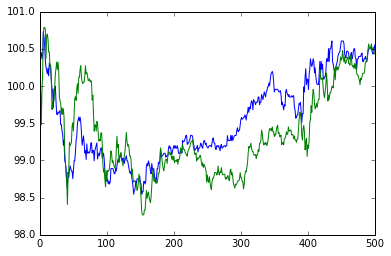

In [20]:
plt.plot(100 * np.cumprod(1 + df_iso.iloc[32,0:500]))
plt.plot(100 * np.cumprod(1 + df_iso.iloc[104,0:500]))
plt.show()

### Now that we've clustered our stocks, we can then do the second part of the strategy, which is to calculate the Kalman Filter. The two functions below plot and calculate the Kalman Filter. The Kalman Filter has two parameters, a slope parameter and intercept paramater. There is some flexibility to change the "delta" parameter to smooth the Kalman Filter. We use the "pykalman" package in python to calculate the filter.

In [21]:
def draw_slope_intercept_changes(prices, state_means):
    """
    Plot the slope and intercept changes from the 
    Kalman Filte calculated values.
    """
    pd.DataFrame(
        dict(
            slope=state_means[:, 0], 
            intercept=state_means[:, 1]
        ), index=prices.index[0:501]
    ).plot(subplots=True)
    plt.show()

In [22]:
def calc_slope_intercept_kalman(stock1, stock2, prices):
    """
    Utilise the Kalman Filter from the pyKalman package
    to calculate the slope and intercept of the regressed
    ETF prices.
    """
    delta = 1e-5
    trans_cov = delta / (1 - delta) * np.eye(2)
    obs_mat = np.vstack(
        [prices.loc[stock1, 0:500], np.ones(prices.loc[stock1, 0:500].shape)]
    ).T[:, np.newaxis]
    
    kf = KalmanFilter(
        n_dim_obs=1, 
        n_dim_state=2,
        initial_state_mean=np.zeros(2),
        initial_state_covariance=np.ones((2, 2)),
        transition_matrices=np.eye(2),
        observation_matrices=obs_mat,
        observation_covariance=1.0,
        transition_covariance=trans_cov
    )
    
    state_means, state_covs = kf.filter(prices.loc[stock2, 0:500].values)
    #next_mean, next_covariance = kf.filter_update(state_means[-1], state_covs[-1], observation=143.70, observation_matrix=np.ones((2, 2)))
    #print(next_mean)
    #print(next_covariance)
    
    return state_means, state_covs  

### We then run the Kalman Filter for stocks DISCA and STX for the first 500 minutes of trading data. We then plot the time-varying slope and intercept over the first 500 minutes.

In [23]:
state_means, state_covs = calc_slope_intercept_kalman(df_iso.index[32], df_iso.index[104], df_new)

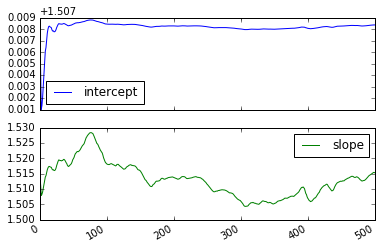

In [24]:
draw_slope_intercept_changes(df_new.transpose(), state_means)

### The next two functions "update" the Kalman Filter prediction based on new price data. We use the next 1,000 minutes of trading data update the prediction, then calculate the error of the prediction. The idea is that when the prediction deviates from the error by one standard deviation (which is also time-varying), we should either "go long" or "go short" the spread.

In [25]:
def getError(theta, state_covs, latest_prices):
    #delta = 1e-4
    #wt = delta / (1 - delta) * np.eye(2)
    vt = 1e-3
    ##theta = np.zeros(2)
    #theta = state_means[1]
    P = np.zeros((2, 2))
    ##R = None
    #R = state_covs[1]
    R = state_covs
    #latest_prices = [100,200]
    F = np.asarray([latest_prices[0], 1.0]).reshape((1, 2))
    y = latest_prices[1]
    yhat = F.dot(theta)
    et = y - yhat
    Qt = F.dot(R).dot(F.T) + vt
    sqrt_Qt = np.sqrt(Qt)
    return et, sqrt_Qt

In [26]:
def getUpdate(theta, state_covs, latest_prices):
    delta = 1e-4
    wt = delta / (1 - delta) * np.eye(2)
    vt = 1e-3
    ##theta = np.zeros(2)
    #theta = state_means[1]
    P = np.zeros((2, 2))
    ##R = None
    #R = state_covs[1]
    R = state_covs
    #latest_prices = [100,200]
    F = np.asarray([latest_prices[0], 1.0]).reshape((1, 2))
    y = latest_prices[1]
    yhat = F.dot(theta)
    et = y - yhat
    Qt = F.dot(R).dot(F.T) + vt
    sqrt_Qt = np.sqrt(Qt)
    At = R.dot(F.T) / Qt
    new_theta = theta + At.flatten() * et
    C = R - At * F.dot(R)
    new_R = C + wt
    return new_theta, new_R

In [27]:
start = 500
state_means_new = []
state_means_new.append(state_means[-1])
state_covs_new = []
state_covs_new.append(state_covs[-1])
error_list = []
stdev_list = []

for x in range(1, 1000):
    new_price_1 = df_new.loc[df_iso.index[32], start+x]
    new_price_2 = df_new.loc[df_iso.index[104], start+x]

    my_error, my_stdev = getError(state_means_new[-1], state_covs_new[-1], [new_price_1, new_price_2])
    my_new_theta, my_new_R = getUpdate(state_means_new[-1], state_covs_new[-1], [new_price_1, new_price_2])
    state_means_new.append(my_new_theta)
    state_covs_new.append(my_new_R)
    error_list.append(my_error)
    stdev_list.append(my_stdev[0])

In [28]:
neg_stdev_list = []
for s in stdev_list:
    neg_stdev_list.append(s * -1) 

### We plot the error of our prediction over the next 1,000 minutes below. Remember, each minute, the Kalman Filter was updated using the most recent prices, to generate a new prediction. The prediction is compared to the actual spread that trading day to obtain the error. The green and red lines represent our standard deviation "boundary". When the error exceeds the boundary we should "go long" or "go short" the spread.

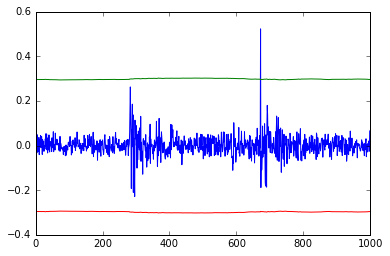

In [29]:
plt.plot(error_list)
plt.plot(stdev_list)
plt.plot(neg_stdev_list)
plt.show()

### In the future, we could use the QS Trader package in Python to rigorously back-test the strategy. Any strategy will have to take into account the bid-offer spread and other trading frictions that will most likely reduce our theoretical profit.